In [1]:
# https://stackoverflow.com/questions/51501074/implementing-mclp-in-pul

import numpy as np
import pandas as pd
from pulp import *
import matplotlib.pyplot as plt
from kneed import KneeLocator
import folium
from folium import plugins
from matplotlib import rc

In [2]:
rc('font', family='AppleGothic')

plt.rcParams['axes.unicode_minus'] = False

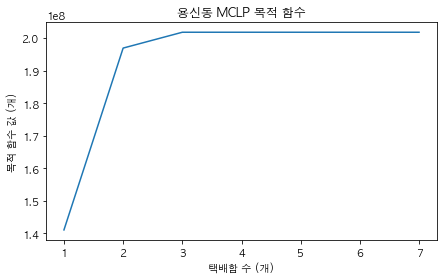

2


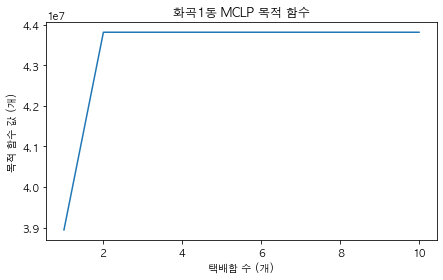

2


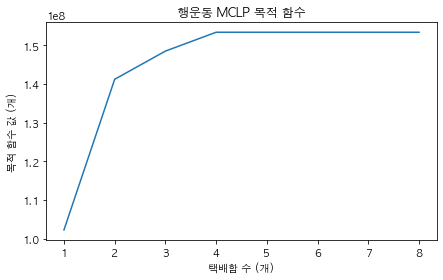

2


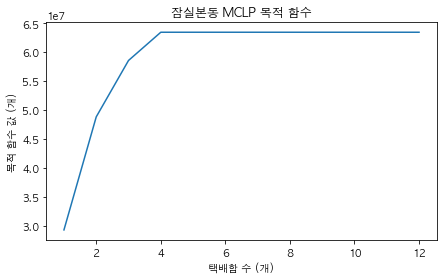

4


In [8]:
dongs = ['용신동', '화곡1동', '행운동', '잠실본동']
elbow_points = []
for dong in dongs:
    file_name_d = './거리 행렬/' + dong + '_거리_행렬.xlsx'
    file_name_a = './좌표 최종/좌표_' + dong + '_최종_최종.xlsx'
    
    d = pd.read_excel(file_name_d).iloc[:, 1:] # Distance matrix (Index Column 제외)
    a = pd.read_excel(file_name_a).iloc[:, 0] # 택배 착지량 (수요 데이터로 활용)
    
    for j in range(d.shape[1]):
        for i in range(d.shape[0]):
            d.iloc[i, j] = d.iloc[i, j].replace(' km', '')
        d.iloc[:, j] = d.iloc[:, j].astype(float)

    d = d.values
    a = a.values

    I = [i for i in range(d.shape[0])] # 수요지 index array
    J = [j for j in range(d.shape[1])] # 후보지 index array
    S = 0.5 # 최대 커버 지역 500m 설정

    N = [[j for j in J if d[i][j] < S] for i in I]

    # 택배함 수 변화 시키면서 반복

    answers = []
    zs = []

    for num_of_fac in range(1, len(J) + 1):

        prob = LpProblem("MCLP", LpMaximize)
        
        x = LpVariable.dicts("x", J, cat = 'Binary') # 후보지
        y = LpVariable.dicts("y", I, cat = 'Binary') # 수요지

        prob += lpSum([a[i] * y[i] for i in I]) # 목적함수

        # 제약식
        for i in I:
            prob += lpSum([x[j] for j in N[i]]) >= y[i]

        prob += lpSum([x[j] for j in J]) == num_of_fac

        prob.solve()

        x_soln = np.array([x[j].varValue for j in J])
        answers.append(x_soln)
        zs.append(value(prob.objective))
        
    plt.figure(figsize = (7, 4))
    plt.plot(range(1, len(J) + 1), zs)
    plt.xlabel('택배함 수 (개)')
    plt.ylabel('목적 함수 값 (개)')
    plt.title(dong + ' MCLP 목적 함수')
    plt.savefig(dong + '_MCLP')
    plt.show()
    
    kn = KneeLocator(range(1, len(J) + 1), zs, curve = 'concave', direction='increasing')
    print(kn.knee)
    elbow_points.append(answers[kn.knee - 1])

In [11]:
CENTER = [37.5648406, 126.9773030] # 서울 시청
m = folium.Map(location=CENTER, zoom_start=11)

for i, dong in enumerate(dongs):
    print(dong)
    print()
    
    public = pd.read_excel('./공공시설/' + dong + '.xlsx')
    block = pd.read_excel('./좌표 최종/좌표_' + dong + '_최종_최종.xlsx')
    
    result = public.loc[(np.where(elbow_points[i] == 1)[0]), :]
    
    for row_index, row in enumerate(public.itertuples()):
        if row_index in (np.where(elbow_points[i] == 1)[0]):
            print(public.at[row_index, '이름'])
            location = [float(public.at[row_index, '위도']), float(public.at[row_index, '경도'])]
            folium.Marker(location, tooltip='<b>{}</b>'.format(public.at[row_index, '이름'])).add_to(m)

    location_data = block[['위도', '경도', '택배 착지량']].values[:len(block)].tolist()
    plugins.HeatMap(location_data).add_to(m)
    print()
#m.save('시각화_최종_MCLP.html')

용신동

용신동 주민센터
용두 어린이 영어 도서관

화곡1동

필마어린이공원
솔뫼어린이공원

행운동

장미어린이공원
서울대입구역

잠실본동

잠실본동 주민센터
아시아공원공영주차장
새마을시장 노상 공영 주차장
삼전역



In [5]:
CENTER = [37.5648406, 126.9773030] # 서울 시청
m = folium.Map(location=CENTER, zoom_start=11)

for i, dong in enumerate(dongs):
    public = pd.read_excel('./공공시설/' + dong + '.xlsx')
    result = public.loc[(np.where(elbow_points[i] == 1)[0]), :]
    
    for row_index, row in enumerate(public.itertuples()):
        if row_index in (np.where(elbow_points[i] == 1)[0]):
    
            location = [float(public.at[row_index, '위도']), float(public.at[row_index, '경도'])]
            folium.Marker(location, tooltip='<b>{}</b>'.format(public.at[row_index, '이름'])).add_to(m)

m.save('시각화_공공시설_MCLP.html')